### Dataset link: http://medicalsegmentation.com/covid19/

* ground-glass (mask value =1)
* consolidation (=2) 
* pleural effusion (=3)

In [1]:
# Import libraries

import os
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline
import nibabel as nib
import numpy as np
from skimage.transform import resize
import scipy.misc
from skimage.transform import rotate
from skimage.io import imread, imshow, imread_collection, concatenate_images

ROOT_DIR = os.path.abspath("../")
DATASET_NAME = "COVID19"
DATASET_PATH = os.path.join(ROOT_DIR, "datasets", DATASET_NAME)
print(os.listdir(DATASET_PATH))

#Data tree
# stage1_train

['tr_mask.nii', 'tr_mask.nii.gz', 'tr_im.nii', 'tr_im.nii.gz']


In [2]:
def hu_window(image):
    "Normalize"
    
    # For lung
    #############
    MIN_HU = -512
    MAX_HU = 512
    #############
    
    image[image < MIN_HU] = MIN_HU
    image[image > MAX_HU] = MAX_HU
    image = (image - MIN_HU) / (MAX_HU - MIN_HU)
    image = image.astype("float32")
    return image


# Helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    
    norm=plt.Normalize(0,3) # 4 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","green","blue"])

    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        #plt.imshow(image, cmap=map_name, norm=norm)
        plt.imshow(image)
    plt.show()

In [3]:
vol_path = DATASET_PATH + "/tr_im.nii" # tr_mask.nii.gz
mask_path = DATASET_PATH + "/tr_mask.nii"
vol_path, mask_path

('/home/hasib/gaussianU-Net/datasets/COVID19/tr_im.nii',
 '/home/hasib/gaussianU-Net/datasets/COVID19/tr_mask.nii')

In [4]:
# Read CT
vol = nib.load(vol_path)
masks = nib.load(mask_path)

In [5]:
vol = np.asanyarray(vol.dataobj)
masks = np.asanyarray(masks.dataobj)
vol.shape, masks.shape

((512, 512, 100), (512, 512, 100))

In [6]:
vol = rotate(vol, -90, resize=False)  
masks = rotate(masks, -90, resize=False)  

In [7]:
# Normalize
vol = hu_window(vol)
vol.shape

(512, 512, 100)

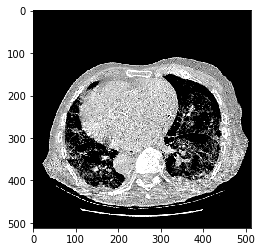

In [8]:
plt.imshow(vol[:,:,0], cmap='gray')

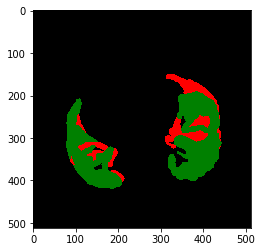

In [9]:
norm=plt.Normalize(0,3) # 4 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","green","blue"])
plt.imshow(masks[:,:,0], cmap=map_name, norm=norm)

In [10]:
CLASSES = ['groundglass', 'consolidation', 'pleuraleffusion']
class_values = [CLASSES.index(cls) + 1 for cls in CLASSES]
class_values

[1, 2, 3]

In [11]:
#https://github.com/hasibzunair/MoNuSAC-ISBI-2020/blob/master/3_train.ipynb

In [12]:
# Extract certain classes from mask
masks = [(masks == v) for v in class_values]
masks = np.stack(masks, axis=-1).astype('float')
# Add background if mask is not binary
if masks.shape[-1] != 1:
    background = 1 - masks.sum(axis=-1, keepdims=True)
    masks = np.concatenate((masks, background), axis=-1)
    
masks.shape

(512, 512, 100, 4)

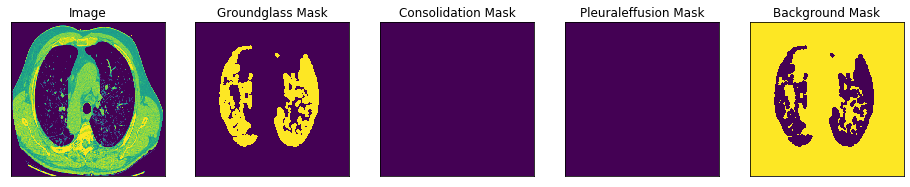

In [13]:
ct = 98

visualize(
    image=vol[:,:,ct], 
    GroundGlass_mask = masks[:,:,ct,0],
    Consolidation_mask = masks[:,:,ct,1],
    PleuralEffusion_mask = masks[:,:,ct,2],
    background_mask = masks[:,:,ct,3],
)

In [14]:
images = []
maps = []

for idx in range(100):
    # Resize image
    img = np.expand_dims(resize(vol[:,:,idx], (256,256)), axis=-1)
    images.append(img)
    
    
    # Resize masks
    msk = resize(masks[:,:,idx], (256,256))
    maps.append(msk)
    
images = np.array(images)
maps = np.array(maps)

print(images.shape, maps.shape)    

(100, 256, 256, 1) (100, 256, 256, 4)


In [30]:
a = maps[0]
a.shape

(256, 256, 4)

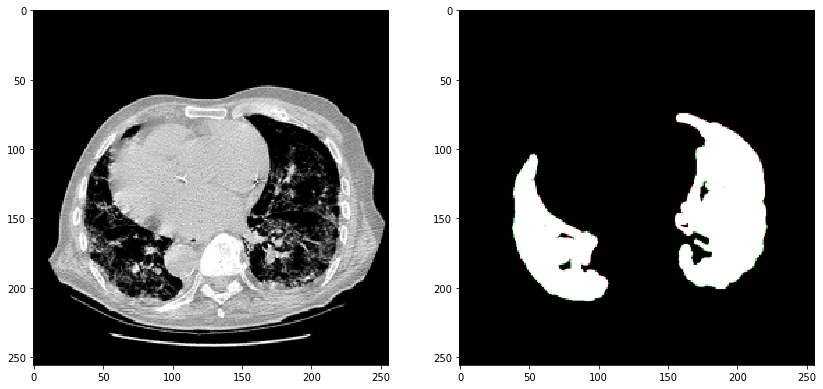

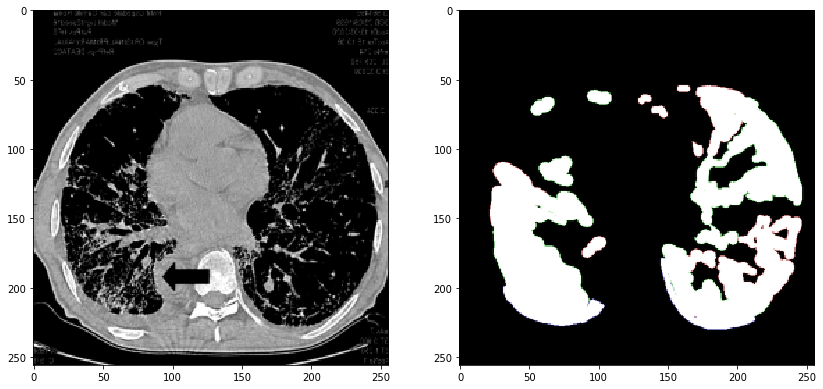

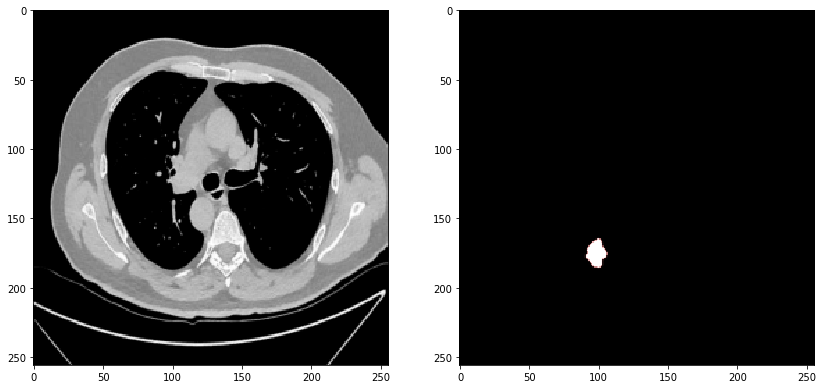

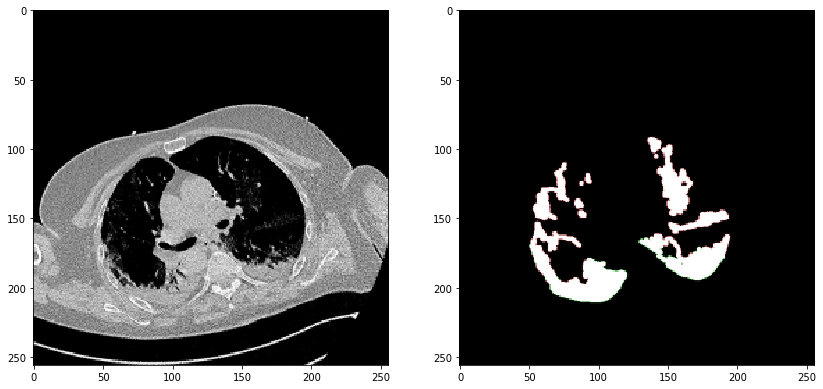

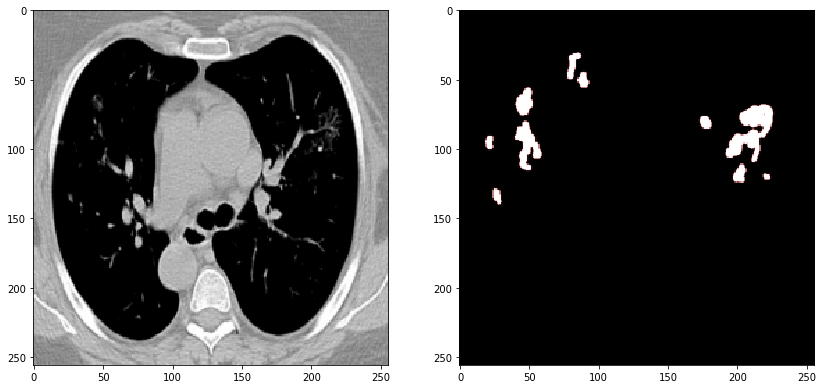

In [33]:
for img, mask in zip(images[:5], maps[:5]):
    
    norm=plt.Normalize(0,3) # 4 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","green","blue"])

    #mask = np.squeeze(mask, axis=-1) # change to H, W
    
    
    fig,_ = plt.subplots(nrows=1, ncols=2, figsize=(14,12))
    fig.axes[0].imshow(img.squeeze(), cmap='gray')
    fig.axes[1].imshow(mask,  cmap=map_name, norm=norm)
    plt.show()

In [36]:
images.shape, maps.shape

((100, 256, 256, 1), (100, 256, 256, 4))

In [37]:
np.save("{}/COVID19_images.npy".format(DATASET_PATH), images)
np.save("{}/COVID19_mask.npy".format(DATASET_PATH), maps)